# Regression and forecasting with sktime-dl
[Github](https://github.com/sktime/sktime-dl)

In this notebook, we use sktime-dl to perform regression and forecasting on univariate time series data by deep learning.

See [sktime](https://github.com/alan-turing-institute/sktime/blob/master/examples/forecasting.ipynb) for the same forecasting performed using time series algorithms.

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sktime.datasets import load_shampoo_sales, load_italy_power_demand
from sktime.forecasting.compose import RecursiveTimeSeriesRegressionForecaster
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime_dl.regression import CNNRegressor, MLPRegressor

sns.set_style('whitegrid') 

# Regression
First, we create a dataset of regression values against time series data samples.

In [2]:
X_train, y_train = load_italy_power_demand(split='train', return_X_y=True)
X_test, y_test = load_italy_power_demand(split='test', return_X_y=True)

# Create some regression values. 
# Make the value y equal to the sum of the X values at time-steps 1 and 10.
y_train = np.zeros(len(y_train))
for i in range(len(X_train)):
    y_train[i] = X_train.iloc[i].iloc[0].iloc[1]
    y_train[i] = y_train[i] + X_train.iloc[i].iloc[0].iloc[10]
y_test = np.zeros(len(y_test))
for i in range(len(X_test)):
    y_test[i] = X_test.iloc[i].iloc[0].iloc[1]
    y_test[i] = y_test[i] + X_test.iloc[i].iloc[0].iloc[10]

## Plot the dataset's regression values

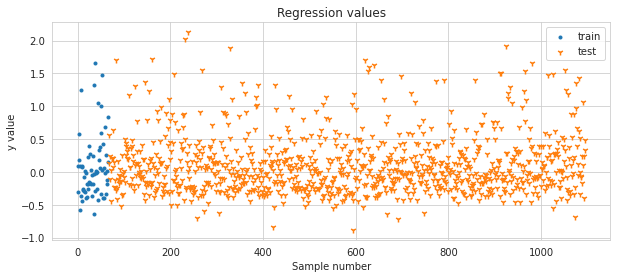

In [3]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
ax_train = np.arange(len(y_train))
ax_test = np.arange(len(y_train), len(y_train)+len(y_test))
plt.scatter(ax_train, y_train, marker='.',label="train")
plt.scatter(ax_test, y_test, marker='1', label="test")
plt.title('Regression values')
ax.set(ylabel='y value')
ax.set_xlabel('Sample number')
plt.legend();

## Train and test a deep learning model
Here, we choose use the CNN (convolutional neural network) model. Other regressors provided by sktime-dl include MLP, ResNet and InceptionTime.

In [4]:
estimator = CNNRegressor(nb_epochs=400, kernel_size=7, verbose=False)
estimator.fit(X_train, y_train)
y_predict = estimator.predict(X_test)
print('Regression score:', estimator.score(X_test, y_test))

Regression score: 0.836166590717957


## Plot the result

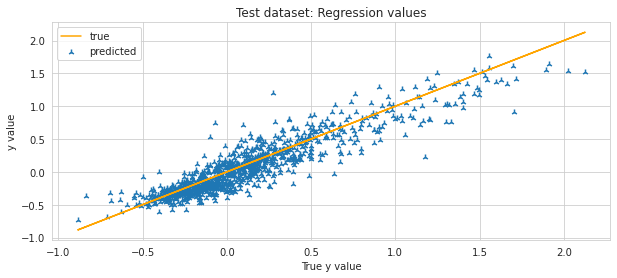

In [5]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
ax_train = np.arange(len(y_train))
ax_test = np.arange(len(y_train), len(y_train)+len(y_test))
plt.plot(y_test, y_test, label="true", c='orange')
plt.scatter(y_test, y_predict, marker='2', label="predicted")
plt.title('Test dataset: Regression values')
ax.set(ylabel='y value')
ax.set_xlabel('True y value')
plt.legend();

# Forecasting
## Load a dataset
Load shampoo sales dataset from sktime containing monthly sale counts of shampoo over three years.

In [6]:
shampoo_series = load_shampoo_sales()
shampoo_series.head()

Period
1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

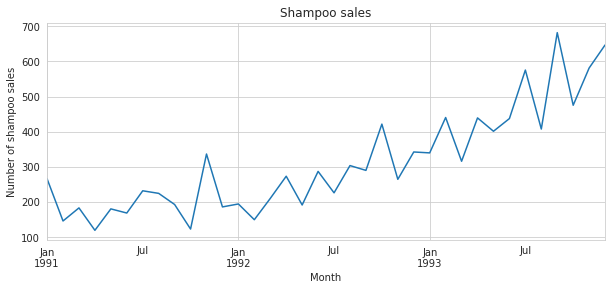

In [7]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
shampoo_series.plot(ax=ax)
plt.title('Shampoo sales')
ax.set(ylabel=shampoo_series.name)
ax.set_xlabel('Month');

## Split the data into training and test data
We will train a neural network to forecast shampoo sales over the next 6 months, using the first 30 months of data.

In [8]:
train, test = temporal_train_test_split(shampoo_series, test_size=6)

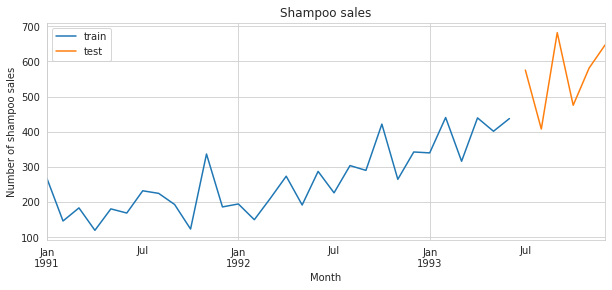

In [9]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.title('Shampoo sales')
ax.set(ylabel=shampoo_series.name)
ax.set_xlabel('Month')
plt.legend();

## Train and test a deep learning model

A reduction strategy allows us to solve forecasting tasks using a deep learning time-series regressor and a rolling window approach.

In [10]:
window_length=10
fh = [1, 2, 3, 4, 5, 6] # forecasting horizon

regressor = MLPRegressor(nb_epochs=500, verbose=False)

forecaster = RecursiveTimeSeriesRegressionForecaster(
                estimator=regressor, 
                window_length=window_length)
forecaster.fit(train)
predict = forecaster.predict(fh)

In [11]:
# Evaluate the forecast (root mean squared error)
np.sqrt(mean_squared_error(test, predict))

125.35559120428135

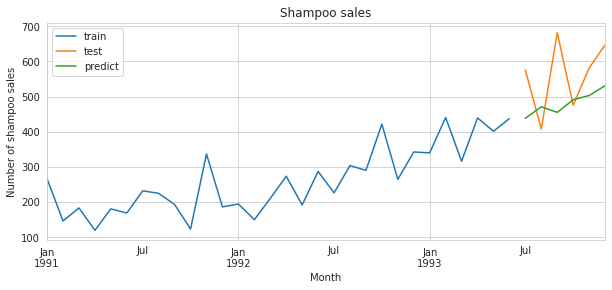

In [12]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
predict.plot(ax=ax, label='predict')
plt.title('Shampoo sales')
ax.set(ylabel=shampoo_series.name)
ax.set_xlabel('Month')
plt.legend();